In [214]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("paper")

import numpy as np
import pandas as pd
import geopandas as gpd
from geopandas import GeoDataFrame

from sqlalchemy import create_engine
engine = create_engine('postgresql://user:@localhost:5432/postgres')
conn = engine.connect()
from geoalchemy2 import Geometry, WKTElement

from sklearn import model_selection
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")


In [217]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
import  statsmodels.stats.diagnostic as diag
import patsy

from sklearn.cluster import KMeans

Helper functions

In [218]:
def stdarize(X):
    std = np.std(X)
    mean = np.mean(X)
    
    return((X-X.mean())/X.std())

def percentage_change(X):
    std = np.std(X)
    mean = np.mean(X)
    
    return(X/X.mean())-1



In [219]:
def round_ceil_decade(x):
    return(int(np.ceil(x/10)*10))

In [222]:
palette = {"A":"#5FCE72","B":"#0BC0ED","C":"#FFD419","D":"#FF4B19"}
# ur_palette = {0:"#5901E3",1:"#E30130"}
ur_palette = {0:"#4A4A4A",1:"#E30130"}
ur_palette1 = {0:'#4A4A4A',1:'#FF3327'}
ur_palette2 = {0:'#4A4A4A',1:'#000CFF'}


D_highlight_palette = {"A":"#b2b2b2","B":"#b2b2b2","C":"#b2b2b2","D":"#FF4B19"}
D_highlight_palette2 = {"not_D":"#6b6b6b","D":"#FF4B19"}


In [223]:
fips_codes = pd.read_csv('state_fips.csv',dtype=str).rename(columns={'State (FIPS)':'State'})

# Purpose
- Explore renewal boundaries and public housing data
- Also explore HISDAC: see whether the BUI lines up with UR boundaries? 


# 0. Prep Data
## 0.1 Load the results data

In [225]:
df_results=gpd.read_postgis('select * from ur_tracts_preds_6',con=conn).drop_duplicates(subset=['gisjoin'])


In [226]:
w_rf=1
w_nn=1.5
w_gb=1.5

df_results['avg_pred_1'] = df_results[['rf_pred_1','nn_pred_1','gb_pred_1']].apply(lambda x: (w_rf*x['rf_pred_1']+w_nn*x['nn_pred_1']+w_gb*x['gb_pred_1'])/(w_rf+w_nn+w_gb),axis=1)


In [227]:
# df_1['ur1'] = df_1['avg_pred_1']
# df_2['ur2'] = df_2['avg_pred_1']
# df_4['ur4'] = df_4['avg_pred_1']
# df_5['ur5'] = df_5['avg_pred_1']
# df_6['ur6'] = df_6['avg_pred_1']

# df_3['ur3'] = df_2['avg_pred_1'].apply(lambda x: 1 if x>thres else 0)

In [229]:

perc_median = []
thres_cal = np.linspace(.5,.9,40)
for thres in thres_cal:
    # df_ur = df_6.copy()
    df_results['has_ur_new_new'] = df_results['avg_pred_1'].apply(lambda x: 'yes' if x>=thres else 'no')
    df_results['has_ur_new'] = df_results.apply(lambda x: 1 if x['has_ur_new_new']=='yes' else (1 if x['has_ur']=='yes' else 0),axis=1)
    df =df_results.copy()

    t = df.groupby(['STATE','COUNTY','NAME','has_ur_new','has_ur']).count()[['gisjoin']]
    t_tot = df.groupby(['STATE','COUNTY','NAME',]).count()[['gisjoin']]
    perc = (t/t_tot).reset_index()

    med = perc[(perc['has_ur_new']==1)].groupby(['STATE','COUNTY','NAME']).sum()['gisjoin'].describe()['50%']
    perc_median.append(med)

Text(0, 0.5, 'Share of Tracts Predicted')

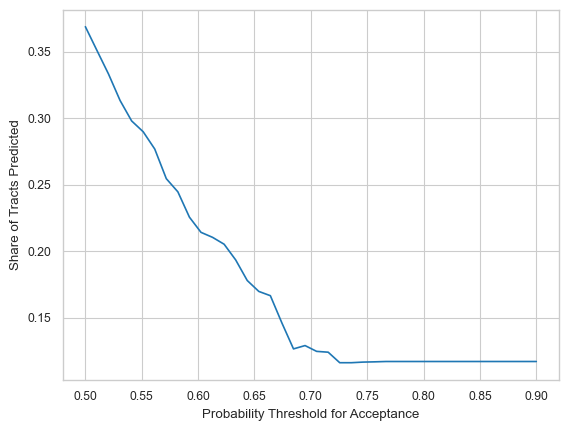

In [181]:
plt.plot(thres_cal,perc_median)
plt.xlabel('Probability Threshold for Acceptance')
plt.ylabel('Share of Tracts Predicted')


In [230]:
thres = 0.7
df_results['has_ur_new_new'] = df_results['avg_pred_1'].apply(lambda x: 'yes' if x>=thres else 'no')
df_results['has_ur_new'] = df_results.apply(lambda x: 1 if x['has_ur_new_new']=='yes' else (1 if x['has_ur']=='yes' else 0),axis=1)
df =df_results.copy()

Clean data

In [231]:
df = df.drop(columns=[ 'median_income_adj',
       'median_income', 'Total_units', '1940_later', '1930_1939', '1920_1929',
       '1910_earlier', '1940_later_perc', '1930_1939_perc', '1920_1929_perc',
       '1910_earlier_perc', 'hispanic_perc', 'hispanic', 'asian_perc', 'asian',
       'unemployed', 'unemployed_perc', ])

Add in pop dens 

In [234]:
for y in [1940,1950,1960,1970,1980,1990,2000,2010]:
    df['pop_dens_{}'.format(y)] = df['population_{}'.format(y)]/df.geom.to_crs("epsg:3857").area
    
    ## Create a category that is non-white percentage
    df['nonwhite_perc_{}'.format(y)] = 1-df['white_perc_{}'.format(y)]
    df['nonwhite_{}'.format(y)] = df['population_{}'.format(y)]-df['white_{}'.format(y)]

Get neighbors

In [235]:
df['is_neigh'] = 0
for tract in df[df['has_ur_new']==1]['gisjoin'].unique():  
    neighbors = [x for x in set(np.array(df[df['geom'].touches(df[df['gisjoin']==tract].head(1)['geom'].values[0])]['gisjoin']))]
    df.loc[df['gisjoin'].isin(neighbors),'is_neigh']=1

In [332]:
df.rename(columns = {'has_ur_new':'UR_new',
                    'has_ur':'UR_dsl'})[['gisjoin','UR_new','UR_dsl','geom']].to_file('ur_tracts',driver='GeoJSON')

In [189]:
df.to_postgis('ur_tracts_preds_final_test', 
                                 engine, 
                                 if_exists='replace',
                                 index=False, 
                                 dtype={'geom': Geometry(geometry_type='MultiPolygon', srid= 4326)})

## 0.1 Data on Urban Renewal Areas
- For now, using these categories:
    - 'urban renewal grants approved/reserved'
    - 'project status'
    - 'white families', 'non-white families','total families'
    - 'proposed reuse of project land- total',
    

### 0.1.1 Get the UR boundaries that we currently have

In [236]:
ur_boundaries = gpd.read_file('../data/DSL/UR_Projects_cleaned/ur_projects_cleaned.shp')
# Format names for consistency
ur_boundaries['city'] = ur_boundaries['city'].replace(['nyc'],value='New York')
ur_boundaries['city'] = ur_boundaries['city'].str.replace('_',' ')
ur_boundaries['city'] = ur_boundaries['city'].str.title()

ur_boundaries['city'] = ur_boundaries['city'].replace(['Nyc'],'New York')
ur_boundaries['city'] = ur_boundaries['city'].replace(['Philadelphia\r\n'],'Philadelphia')

ur_boundaries['project'] = ur_boundaries['project'].str.title()

## Remove duplicate geometries
ur_boundaries = ur_boundaries.groupby('project_id').first().reset_index()
ur_boundaries = ur_boundaries.set_crs(epsg=4326)

## Format names for consistency
ur_boundaries['state'] = ur_boundaries['state'].str.upper()


### 0.1.2 Get the UR Projects Data

In [237]:
ur_data = pd.read_csv('../data/DSL/UR_Projects/non_spatial_data.csv')

## Format names for consistency
ur_data['city'] = ur_data['city'].replace(['nyc'],value='New York')
ur_data['city'] = ur_data['city'].str.title()

ur_data['state'] = ur_data['state'].str.upper()

ur_data['project'] = ur_data['project'].str.title()

Create a table of the latest amt approved and dispursed for each UR project

In [238]:
ur_project_res_first = ur_data[(ur_data.cat== 'urban renewal grants approved/reserved')]\
                                .sort_values(['project_id','project','city','state','year'])\
                                .groupby(['project_id','project','city','state'])\
                                .first()[['value','year']]\
                                .reset_index().rename(columns={'value':'amt_reserved_first',
                                                                'year':'amt_reserved_year_first'})

ur_project_res_first1 = ur_project_res_first[ur_project_res_first.amt_reserved_first.isna()==False]

## Now create a column indicated when is the first census year these effects would show in the data
ur_project_res_first1['census_year_first'] = ur_project_res_first1['amt_reserved_year_first'].apply(round_ceil_decade)

In [239]:
ur_project_res_last = ur_data[(ur_data.cat== 'urban renewal grants approved/reserved')]\
                                .sort_values(['project_id','project','city','state','year'])\
                                .groupby(['project_id','project','city','state'])\
                                .last()[['value','year']]\
                                .reset_index().rename(columns={'value':'amt_reserved_last',
                                                                'year':'amt_reserved_year_last'})

ur_project_res_last1 = ur_project_res_last[ur_project_res_last.amt_reserved_last.isna()==False]


In [240]:
ur_project_dis_first = ur_data[(ur_data.cat== 'urban renewal grants dispursed')]\
                                .sort_values(['project_id','project','city','state','year'])\
                                .groupby(['project_id','project','city','state'])\
                                .first()[['value','year']]\
                                .reset_index().rename(columns={'value':'amt_dispursed_first',
                                                                'year':'amt_dispursed_year_first'})

ur_project_dis_first1 = ur_project_dis_first[ur_project_dis_first.amt_dispursed_first.isna()==False]


In [241]:
ur_project_dis_last = ur_data[(ur_data.cat== 'urban renewal grants dispursed')]\
                                .sort_values(['project_id','project','city','state','year'])\
                                .groupby(['project_id','project','city','state'])\
                                .last()[['value','year']]\
                                .reset_index().rename(columns={'value':'amt_dispursed_last',
                                                                'year':'amt_dispursed_year_last'})

ur_project_dis_last1 = ur_project_dis_last[ur_project_dis_last.amt_dispursed_last.isna()==False]

Create a table of the latest status for each UR project

In [242]:
ur_project_status = ur_data[ur_data.cat== 'project status']\
                                .sort_values(['project_id','project','city','state','year'])\
                                .groupby(['project_id','project','city','state'])\
                                .last()[['value','year']]\
                                .reset_index()\
                                .rename(columns={'value':'project_status',
                                                'year':'project_status_year'})

Join to project boundaries

In [243]:
ur = ur_boundaries.drop(columns=['city','state'])\
                    .merge(ur_project_res_first1[['project_id','amt_reserved_first','amt_reserved_year_first','census_year_first','project','city','state']],
                        on=['project_id'],
                        how='right')\
                  .rename(columns={'project_y':'project'})\
                  .merge(ur_project_res_last1[['project_id','amt_reserved_last','amt_reserved_year_last']],
                        on=['project_id'],
                        how='right')\
                  .rename(columns={'project_y':'project'})
ur = ur.drop(columns=['project_x'])

In [244]:
print(ur_boundaries.shape,ur.shape)

(740, 11) (3941, 16)


#### For paper

Calc amount in 2010 

In [245]:
cpi = pd.read_csv('CPI_U_RS.csv')

In [246]:
ur_project_dis_last1['amt_dispursed_last_adj']= ur_project_dis_last1.apply(lambda x: x['amt_dispursed_last']* cpi[cpi['Year']==2010]['CPI'].values[0]/cpi[cpi['Year']==x['amt_dispursed_year_last']]['CPI'].values[0],axis=1)




In [247]:
df[df['has_ur_new']==1].shape

(1052, 313)

Calc the number of displacements.

In [248]:
ur_data[(ur_data.cat.isin(['white families', 'non-white families',]))\
        &(ur_data.value.isna()==False)]\
        .sort_values(['project_id','project','city','state','year'])\
        .groupby(['project_id','project','city','state']).tail(1).sum()['value']


199908.0

By year project had allocated money

In [249]:
ur_data[(ur_data['project'].str.contains('Interim|Demolition|Demonstration|Dev|Enforcement')==False)&\
        (ur_data.value.isna()==False)&\
        (ur_data.value.isna()==False)&\
       (ur_data.cat== 'urban renewal grants approved/reserved')].sort_values(['project_id','project','city','state','year'])\
        .groupby(['project_id']).head(1).groupby('year').count()


,category_id,project_id,value,quarter,unit_of_measurement,cat,project,city,state
year,,,,,,,,,
1957,393,393,393,393,393,393,393,393,393
1958,254,254,254,254,254,254,254,254,254
1959,99,99,99,99,99,99,99,99,97
1960,204,204,204,204,204,204,204,204,204
1961,187,187,187,187,187,187,187,187,187
1962,352,352,352,352,352,352,352,352,352
1966,841,841,841,841,841,841,841,841,841
1967,226,226,226,226,226,226,226,226,226
1968,101,101,101,101,101,101,101,101,101


#### Summary

In [250]:
ur_data_excl = ur_data[ur_data['project'].str.contains('Interim|Demolition|Demonstration|Dev|Enforcement')==False]['project_id']
ur[ur.project_id.isin(ur_data_excl.unique())].groupby(['city','state']).sum().sort_values('amt_reserved_last',ascending=False)

,,project_id,FID,city_id,SHAPE_Leng,conf,Shape_Le_1,Shape_Area,amt_reserved_first,amt_reserved_year_first,census_year_first,amt_reserved_last,amt_reserved_year_last
city,state,,,,,,,,,,,,
Boston,MA,4850,7043.0,1364.0,112255.007912,132.0,143544.535894,28.121254,134067478.0,51054,51090,571589514.0,51304
New York,NY,27363,239285.0,8064.0,80394.983986,211.0,125873.399649,12.329552,314854017.0,98020,98200,443655470.0,98644
Philadelphia,PA,75612,16619.0,14450.0,90226.254409,229.0,149216.983773,24.818694,243288757.0,107925,108120,325109867.0,108454
Chicago,IL,115757,2286.0,12180.0,103409.754790,34.0,112108.079322,30.084029,183282963.0,90156,90310,281182313.0,90768
San Francisco,CA,42977,2035.0,11709.0,48379.408670,0.0,48066.925363,4.252805,145690990.0,21592,21640,264547927.0,21698
...,...,...,...,...,...,...,...,...,...,...,...,...,...
Auburn,AL,1686,0.0,0.0,0.000000,0.0,0.000000,0.000000,27255.0,1957,1960,12111.0,1974
Wyoming,MI,2890,0.0,0.0,0.000000,0.0,0.000000,0.000000,14666.0,1966,1970,11715.0,1974
Alma,MI,2696,0.0,0.0,0.000000,0.0,0.000000,0.000000,13094.0,1966,1970,10724.0,1974


Residential

In [251]:
ur_data[(ur_data.cat.isin(['proposed reuse of project land- residential',
       ]))&(ur_data.value.isna()==False)].sort_values(['project_id','project','city','state','year'])\
        .groupby(['state','city','project_id','project',]).tail(1).sort_values('value',ascending=False)
# .sum()['value']

,category_id,project_id,value,year,quarter,unit_of_measurement,cat,project,city,state
52574,75,1360,847.0,1966,June,acres,proposed reuse of project land- residential,Eastwick,Philadelphia,PA
53812,75,3668,324.0,1966,June,acres,proposed reuse of project land- residential,Queen City No 1,Mercedes,TX
53638,75,2394,321.8,1966,June,acres,proposed reuse of project land- residential,Edgehill,Nashville,TN
49051,75,2833,305.7,1966,June,acres,proposed reuse of project land- residential,Marquette Neighborhood,Muskegon,MI
45867,75,3943,266.6,1966,June,acres,proposed reuse of project land- residential,Monterey (Open Land),South Pasadena,CA
...,...,...,...,...,...,...,...,...,...,...
36721,75,351,0.1,1964,December,acres,proposed reuse of project land- residential,Area D,Worcester,MA
45128,75,1765,0.1,1966,June,acres,proposed reuse of project land- residential,East Church St,Mobile,AL
48910,75,2788,0.1,1966,June,acres,proposed reuse of project land- residential,Grand River,Grand Rapids,MI
48530,75,265,0.1,1966,June,acres,proposed reuse of project land- residential,Broadway-Essex,Lawrence,MA


Commercial

In [252]:
ur_data[(ur_data.cat.isin(['proposed reuse of project land- commercial',
       ]))&(ur_data.value.isna()==False)&(ur_data.project_id!=1507)].sort_values(['project_id','project','city','state','year'])\
        .groupby(['state','city','project_id','project',]).tail(1).sort_values('value',ascending=False).sum()['value']

7998.8

Industrial

In [253]:
ur_data[(ur_data.cat.isin(['proposed reuse of project land- industrial',
       ]))&(ur_data.value.isna()==False)].sort_values(['project_id','project','city','state','year'])\
        .groupby(['state','city','project_id','project',]).tail(1).sum()['value']

9651.8

Public

In [254]:
ur_data[(ur_data.cat.isin(['proposed reuse of project land- public',
       ]))&(ur_data.value.isna()==False)].sort_values(['project_id','project','city','state','year'])\
        .groupby(['state','city','project_id','project',]).tail(1).sum()['value']

7304.5

In [255]:
ur_data[(ur_data.cat.isin(['proposed reuse of project land- total',
       ]))&(ur_data.value.isna()==False)].sort_values(['project_id','project','city','state','year'])\
        .groupby(['state','city','project_id','project',]).tail(1).sum()['value']

61380.4

### 0.1.2.2 Data Cleaning

Broadly, here are the types of projects that should be removed from the data: 
- Later programs that updated UR (to contain less slum clearance/demolition): 
    - Community Renewal
    - Neighborhood Development
    - Code Enforcement
    - **Actually**, going to remove Demolition Project,Interim Asst Prog,Demonstation Projec 
- Outliers: 
    - City is "Connecticut State At Large"

In [256]:
ur1 = ur[(ur['project'].str.contains('Community Renewal|Neighborhood Dev|Code')==False)&\
         (ur['city']!='Connecticut State At Large')]

#### 0.4.2.3 How many of the projects are missing in each city? 

In [257]:
ur1['has_geom'] = ur1.apply(lambda x: 0 if np.isnan(x['Shape_Area'])  else 1, axis=1)

In [258]:
ur_hasgeom_bycity_num = ur1.groupby(['state','city'])\
                        .sum()[['has_geom']]\
                        .rename(columns={'has_geom':'num_notmissing'})
ur_hasgeom_bycity_res = ur1.groupby(['state','city'])\
                        .sum()[['amt_reserved_last']]\
                        .rename(columns={'amt_reserved_last':'amt_reserved'})
ur_hasgeom_bycity_total = ur1.groupby(['state','city'])\
                        .count()[['project_id']]\
                        .rename(columns={'project_id':'total'})

ur_hasgeom_bycity_perc = (ur1.groupby(['state','city'])\
                              .sum()[['has_geom']]\
                              .rename(columns={'has_geom':'num_notmissing'})/ur1.groupby(['state','city'])\
                                                 .count()[['has_geom']]\
                                                 .rename(columns={'has_geom':'num_notmissing'})).rename(columns={'num_notmissing':'perc_notmissing'})

ur_hasgeom_bycity = pd.concat([ur_hasgeom_bycity_num,ur_hasgeom_bycity_res,ur_hasgeom_bycity_perc,ur_hasgeom_bycity_total],axis=1).reset_index()
ur_hasgeom_bycity = ur_hasgeom_bycity.sort_values(['num_notmissing','total'],ascending=False)

In [259]:
ur_hasgeom_bycity.to_csv('results/missing_projects.csv')

## 0.3 City center information

In [260]:
city_centers = gpd.read_file('../data/city_centers/citiesx010g.shp')
city_centers = city_centers.sort_values(['STATE_FIPS','COUNTYFIPS','POP_2010'],ascending=False)\
                            .groupby(['STATE_FIPS','COUNTYFIPS'])\
                            .first()\
                            .reset_index()

# 1. Pivot the dataframe

Create a new UR column

In [261]:
cols_use = ['nonwhite','nonwhite_perc','owned_perc','median_homevalue','median_homevalue_adj','median_income','median_income_adj','pop_dens','population','homes','college_perc']

df_melt = []
for c in cols_use: 
    if c =='population':
        df_col = df[((df.columns[df.columns.str.contains(c)])&(df.columns[df.columns.str.contains('diff')==False]))\
                    &(df.columns[df.columns.str.contains('population_density')==False])\
       |['gisjoin','has_ur','avg_pred_1','has_ur_new','geom']].melt(id_vars=['gisjoin','has_ur','avg_pred_1','has_ur_new','geom'],value_name=c)
        
        df_col['year'] = df_col['variable'].apply(lambda x: int(x.split('_')[1]))
        df_melt.append(df_col.drop(columns=['variable']))
    elif 'adj' in c: 
        df_col = pd.concat([df[((df.columns[df.columns.str.contains(c)])&(df.columns[df.columns.str.contains('diff')==False]))],
           df[['gisjoin']]],axis=1).melt(value_name=c,id_vars=['gisjoin'])
        df_col['year'] = df_col['variable'].apply(lambda x: int(x.split('_')[-1]))
        df_melt.append(df_col.drop(columns=['variable']))
    elif c=='nonwhite': 
        df_col = pd.concat([df[(df.columns[df.columns.str.contains(c)])&(df.columns[df.columns.str.contains('diff|adj|perc')==False])],
           df[['gisjoin']]],axis=1).melt(value_name=c,id_vars=['gisjoin'])
        df_col['year'] = df_col['variable'].apply(lambda x: int(x.split('_')[-1]))
        df_melt.append(df_col.drop(columns=['variable']))
    else: 
        df_col = pd.concat([df[((df.columns[df.columns.str.contains(c)])&(df.columns[df.columns.str.contains('diff')==False])\
                               &(df.columns[df.columns.str.contains('adj')==False]))],
           df[['gisjoin']]],axis=1).melt(value_name=c,id_vars=['gisjoin'])
        df_col['year'] = df_col['variable'].apply(lambda x: int(x.split('_')[-1]))
        df_melt.append(df_col.drop(columns=['variable']))

In [262]:
from functools import reduce
df1 = reduce(lambda x, y: pd.merge(x, y, on = ['gisjoin','year'],how='left'), df_melt)
df1=gpd.GeoDataFrame(df1,crs="EPSG:4326",geometry='geom').reset_index()

## 1.1 Get neighbors of urban renewal tracts.

In [263]:
df1['is_neigh'] = 0
for tract in df1[df1['has_ur_new']==1]['gisjoin'].unique():  
    neighbors = [x for x in set(np.array(df1[df1['geom'].touches(df1[df1['gisjoin']==tract].head(1)['geom'].values[0])]['gisjoin']))]
    df1.loc[df1['gisjoin'].isin(neighbors),'is_neigh']=1

Take the log of each col

In [264]:
cols_use1 = ['nonwhite','nonwhite_perc','median_income_adj','median_homevalue_adj','median_income','median_homevalue','pop_dens','population','college_perc']
for c in cols_use1: 
    df1['ln_{}'.format(c)] = np.log(df1[c]+.00000001)

Create a DF that is either UR or neighbor of UR

In [265]:
df1['ur_or_neigh'] =False
df1.loc[((df1['is_neigh']==1))|(df1['has_ur_new']==1),'ur_or_neigh']=True

In [266]:
df1.groupby(['ur_or_neigh','has_ur_new']).count().to_csv('Results/has_ur_vs_neigh.csv')

# 2. Label each tract by HOLC label

In [267]:
sql = '''
select * from holc_all_dump_4326
'''
holc = gpd.GeoDataFrame.from_postgis(sql, conn,crs={'init':'epsg:4326'}, geom_col='geometry' )

holc['holc_area'] = holc.to_crs("EPSG:3857").area

holc['HOLC_Grade'].replace('Blue','B',inplace=True)
holc['HOLC_Grade'].replace('Green','A',inplace=True)
holc['HOLC_Grade'].replace('Red','D',inplace=True)
holc['HOLC_Grade'].replace('Yellow','C',inplace=True)
holc.loc[holc['HOLC_Grade'].isna(),'HOLC_Grade'] = 'no_grade'

In [268]:
df1_1940 = df1[df1['year']==1940]

In [269]:
df1_1940['tract_area'] = df1_1940.to_crs("EPSG:3857").area

In [270]:
df1_1940_pieces = gpd.overlay(df1_1940[['geom', 'gisjoin','tract_area']], holc.to_crs("EPSG:4326"), how='intersection')

df1_1940_pieces = df1_1940_pieces[df1_1940_pieces.HOLC_Grade.isin(['C', 'D', 'B', 'A'])]
df1_1940_pieces['perc_tract'] = df1_1940_pieces.to_crs({'init':'epsg:3857'}).area/df1_1940_pieces['tract_area']
df1_1940_pieces['perc_holc'] = df1_1940_pieces.to_crs({'init':'epsg:3857'}).area/df1_1940_pieces['holc_area']

In [271]:
df1_1940_pieces_tracts  =df1_1940_pieces.sort_values(['gisjoin','perc_tract']).groupby('gisjoin').tail(1)
df1_1940_pieces_holc  =df1_1940_pieces.sort_values(['gisjoin','perc_holc']).groupby('gisjoin').tail(1)

In [272]:
df1_1940_pieces1 = df1_1940_pieces.sort_values(['gisjoin','perc_tract'],ascending=False).groupby('gisjoin').first().reset_index()

In [273]:
tract_thres = 0.25
df1_1940_holc = df1_1940[df1_1940.gisjoin.isin(
                                        df1_1940_pieces[df1_1940_pieces['perc_tract']>tract_thres].gisjoin)]\
                                .merge(df1_1940_pieces1[['gisjoin','map_id','HOLC_ID','map_name','HOLC_Grade','HOLC_Lette','name']],on='gisjoin')

In [274]:
df1_1940_holc[df1_1940_holc.geom.is_valid==False].geometry = df1_1940_holc[df1_1940_holc.geom.is_valid==False].buffer(0)

In [275]:
df1_1940_holc.to_postgis('ur_tract_1940_holc', engine, if_exists='replace', index=False, 
                         dtype={'geom': Geometry('MultiPolygon', srid= 4326)})

Merge back to longitudinal data

In [276]:
df2 = df1.merge(df1_1940_holc[['gisjoin','tract_area', 'map_id', 'HOLC_ID',
       'map_name', 'HOLC_Grade', 'HOLC_Lette', 'name']],on='gisjoin',how='left')

## Replace 0 with NaN WHY AM I DOING THIS?
df2.loc[df2.median_homevalue_adj==0,'median_homevalue_adj']=np.nan
df2.loc[df2.owned_perc==0,'owned_perc']=np.nan
# df3.loc[df3.white_perc==0,'white_perc']=np.nan
# df3.loc[df3.college_perc==0,'college_perc']=np.nan

df2.loc[df2['HOLC_Grade'].isna(),'HOLC_Grade'] = 'no_grade'

df2['state_name'] = df2['gisjoin'].apply(lambda x: fips_codes[fips_codes['State']==x[:3][1:]]['Name'].values[0])

Fix the strange missing data issue in 1950 median income

In [278]:
infl = cpi[cpi['Year']==2010]['CPI'].values[0]/cpi[cpi['Year']==1950]['CPI'].values[0]
df2.loc[(df2['year']==1950),'median_homevalue_adj'] =df2.loc[(df2['year']==1950),'median_homevalue']


In [279]:
df2_std_state = pd.concat([df2[['year','state_name','HOLC_Grade','map_name','gisjoin','has_ur_new','ur_or_neigh','is_neigh']],
                           df2.groupby(['year','state_name'])[['nonwhite_perc', 'owned_perc',
       'median_homevalue', 'median_homevalue_adj', 'median_income',
       'median_income_adj', 'pop_dens', 'population', 'homes', 'college_perc',
       'ln_nonwhite', 'ln_nonwhite_perc', 'ln_median_income_adj',
       'ln_median_homevalue_adj', 'ln_median_income', 'ln_median_homevalue',
       'ln_pop_dens', 'ln_population', 'ln_college_perc',]].apply(stdarize)],axis=1)

Merge back to cross sectional data

In [280]:
df_holc = df.merge(df1_1940_holc[['gisjoin','tract_area', 'map_id', 'HOLC_ID',
       'map_name', 'HOLC_Grade', 'HOLC_Lette', 'name']],on='gisjoin',how='left')

df_holc.loc[df_holc['HOLC_Grade'].isna(),'HOLC_Grade'] = 'no_grade'

df_holc['state_name'] = df_holc['gisjoin'].apply(lambda x: fips_codes[fips_codes['State']==x[:3][1:]]['Name'].values[0])
# df_holc.loc[df_holc['median_homevalue_adj']==0,'median_homevalue_adj']=np.nan
# df_holc.loc[df_holc['owned_perc']==0,'owned_perc']=np.nan
# df2.loc[df_holc.white_perc==0,'white_perc']=np.nan
# df2.loc[df_holc.college_perc==0,'college_perc']=np.nan

Remove outliers and extra columns

In [281]:
df_holc= df_holc[df_holc.columns[df_holc.columns.str.contains('_y')==False]]

In [282]:
df_holc.groupby(['has_ur_new','HOLC_Grade']).count()['level_0'].to_csv('results/breakdown_counts.csv')

In [295]:
df_holc.to_postgis('ur_tracts_final_holc', engine, if_exists='replace', index=False, 
                         dtype={'geom': Geometry('MultiPolygon', srid= 4326)})

KeyboardInterrupt: 

# 3. Contributors to UR 

In [296]:
from sklearn.linear_model import LogisticRegressionCV,LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import r2_score
from sklearn import model_selection

In [297]:
housing_age_cols = ['Total_units_1950', '1940_later_1950', '1930_1939_1950', '1920_1929_1950',       '1910_earlier_1950', '1940_later_perc_1950', '1930_1939_perc_1950',
       '1920_1929_perc_1950', '1910_earlier_perc_1950',]

In [298]:
X_cols = np.concatenate([df.columns[df.columns.str.contains('1940')],
                         df.columns[df.columns.str.contains('1950')]])

## 3.1 Correlations

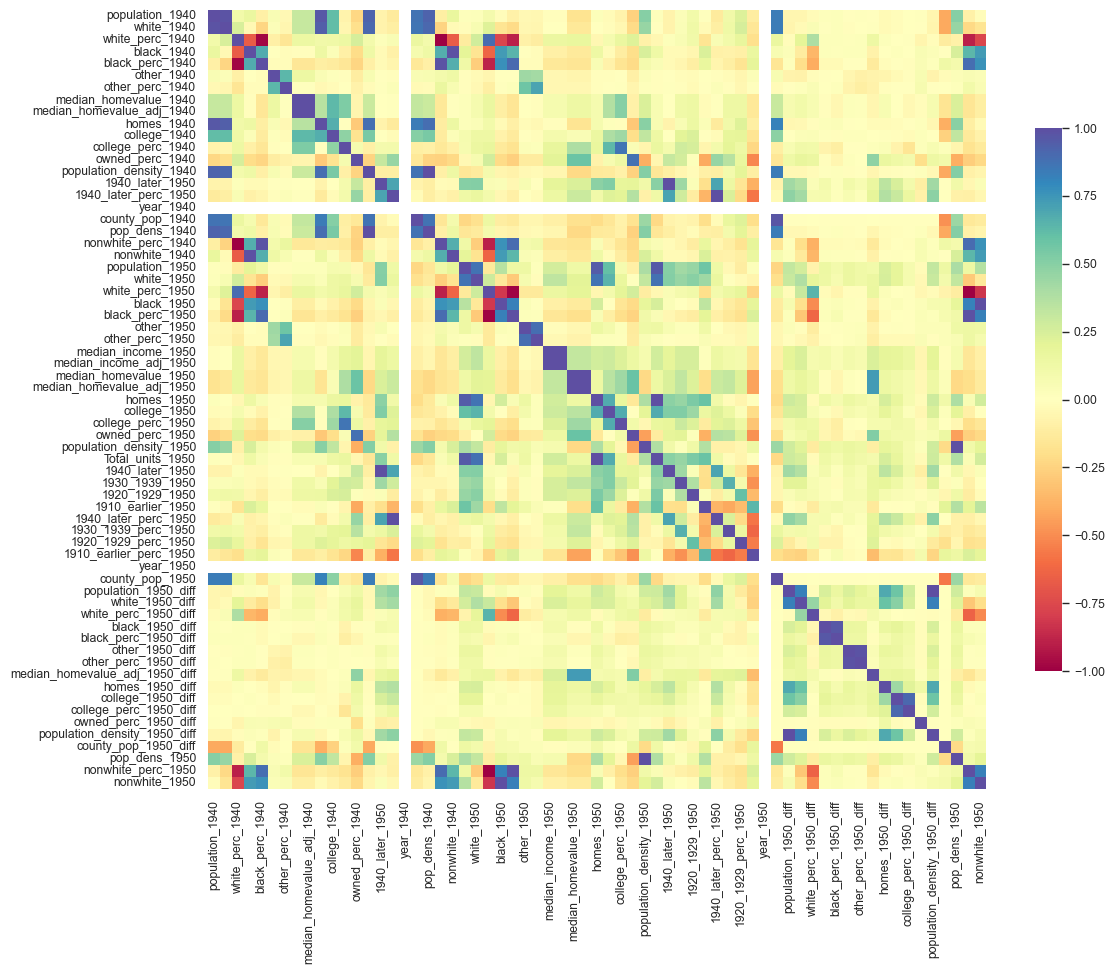

In [292]:
fig,ax = plt.subplots(figsize=(12,12))
cmap = sns.color_palette('Spectral',as_cmap=True)
sns.heatmap(df_holc[X_cols].corr(), center=0,  square=True,
            cmap=cmap,cbar_kws={"shrink": .5})
plt.tight_layout()

plt.savefig('Results/all_corr_reg.svg')

Remove some of high correlations and keep only certain columns

Four regressions: 
1. All Data
2. Just UR and neighbors
3. Just UR and neighbors - only D tracts
4. Just UR and neighbors - only non-D tracts

In [299]:
def clean_data(X,cols_reg):
    
    ## Clean data
    X['median_income_adj_1950'] = X['median_income_adj_1950'].apply(lambda x: np.nan if x ==0 else x)
    X['median_homevalue_adj_1950'] = X['median_homevalue_adj_1950'].apply(lambda x: np.nan if x <=5000 else (np.nan if x>=X['median_homevalue_adj_1950'].max() else x))
    X = X[X['median_income_adj_1950']<1000000]
    X  = X[X['median_homevalue_adj_1950']<1000000]
    X = X[X['population_density_1950']<=.1]
    X['ln_pop_dens_1950'] = np.log(X['pop_dens_1950']+.000001)
    try: 
        
        X['ln_nonwhite_perc_1950_diff'] = np.log(X['nonwhite_perc_1950_diff']+.000001)
    except KeyError as e:
        
        pass
    X['ln_white_perc_1950_diff'] = np.log(X['white_perc_1950_diff']+.000001)
    X['ln_owned_perc_1950_diff'] = np.log(X['owned_perc_1950_diff']+.000001)
    X['ln_population_density_1950_diff']= np.log(X['population_density_1950_diff']+.000001)
    X['ln_college_perc_1950_diff']= np.log(X['college_perc_1950_diff']+.000001)

    
    
#     X1 = stdarize(X[cols_reg])
    X1 = X.groupby(['state'])[cols_reg].apply(stdarize)
    if 'HOLC_Grade' in cols_reg:
        X1 =pd.merge(X1.fillna(np.mean(X1)),X[['HOLC_Grade']],left_index=True,right_index=True)
    else: 
        X1 =X1.fillna(np.mean(X1))
        
#     X1 = X1[cols_reg]
    
    return X1

In [300]:
df_holc['state_name'] = df_holc['state'].apply(lambda x: fips_codes[fips_codes['State']==x]['Name'].values[0])

Get nonwhite percentage

In [301]:
df_holc['nonwhite_perc_1950'] = 1-df_holc['white_perc_1950']
df_holc['nonwhite_perc_1950_diff'] = (1-df_holc['white_1950'])-(1-df_holc['white_1940'])
df_holc['college_perc_1950_diff'] = (df_holc['college_perc_1950']- df_holc['college_perc_1940'])

In [302]:
from statsmodels.stats.anova import anova_lm


In [303]:
cols_reg = ['dist_to_center','nonwhite_perc_1950', 'median_homevalue_adj_1950',
         'owned_perc_1950',
     'teens_earlier_perc_1950',
           'ln_pop_dens_1950', 'ln_nonwhite_perc_1950_diff',
           'ln_owned_perc_1950_diff', 'population_density_1950_diff','ln_college_perc_1950_diff']

In [304]:
## Clean data
X= clean_data(df_holc.rename(columns={'1910_earlier_perc_1950':'teens_earlier_perc_1950'}),cols_reg)
# ## Dummy
holc_grade =df_holc.loc[X.index]['HOLC_Grade']
y = df_holc.loc[X.index]['has_ur_new']
state = df_holc.loc[X.index]['state_name']
df_reg1 = pd.concat([X,y,holc_grade,state],axis=1)


## Clean data
X_neigh = clean_data(df_holc[df_holc.gisjoin.isin(df1[df1['ur_or_neigh']==True]['gisjoin'])].rename(columns={'1910_earlier_perc_1950':'teens_earlier_perc_1950'}),
                     cols_reg)
y_neigh = df_holc.loc[X_neigh.index]['has_ur_new']
state_neigh = df_holc.loc[X_neigh.index]['state_name']
holc_grade_neigh =df_holc.loc[X_neigh.index]['HOLC_Grade']

df_reg2 = pd.concat([X_neigh,y_neigh,holc_grade_neigh,state_neigh],axis=1)

## Regression formulas
f1='has_ur_new ~ ' +' + '.join(cols_reg)+' + nonwhite_perc_1950:median_homevalue_adj_1950'\
+' + teens_earlier_perc_1950:nonwhite_perc_1950+C(state_name)'

f1_holc='has_ur_new ~ ' +' + '.join(cols_reg)+' + nonwhite_perc_1950:median_homevalue_adj_1950'\
+' + teens_earlier_perc_1950:nonwhite_perc_1950'+'+C(state_name) + C(HOLC_Grade)'


f2='has_ur_new ~ ' +' + '.join(cols_reg)+' + nonwhite_perc_1950:median_homevalue_adj_1950'\
+' + teens_earlier_perc_1950:nonwhite_perc_1950'+' + nonwhite_perc_1950:median_homevalue_adj_1950 +C(HOLC_Grade)+C(state_name)'


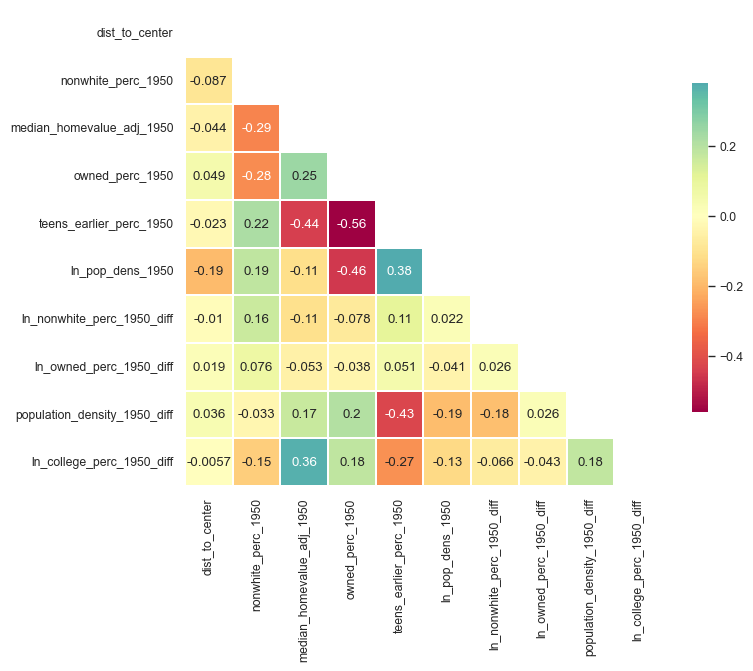

In [305]:
fig,ax = plt.subplots(figsize=(8,8))
cmap = sns.color_palette('Spectral',as_cmap=True)
# cmap = sns.diverging_palette(0, 200,s=160,center='light', as_cmap=True)
mask = np.triu(np.ones_like(X.corr(), dtype=np.bool))

sns.heatmap(X.corr(), center=0,  square=True,mask=mask,annot=True,
            cmap=cmap,cbar_kws={"shrink": .5},linewidths=.1,linecolor='white')
plt.tight_layout()

plt.savefig('Results/colsuse_corr_reg.svg')

**Standard Logistic**

## 3.2 All Data

In [306]:
lr = smf.logit(formula=f1_holc,data=df_reg1,missing='drop',).fit_regularized(cov_type='cluster',cov_kwds={'groups': df_reg1['state_name']})
#                                                                          'cluster',cov_kwds={'groups': df_reg1['state_name']})
lr.summary()

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.15000558313033488
            Iterations: 389
            Function evaluations: 390
            Gradient evaluations: 389


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             has_ur_new   No. Observations:                 5363
Model:                          Logit   Df Residuals:                     5320
Method:                           MLE   Df Model:                           42
Date:                Sat, 04 May 2024   Pseudo R-squ.:                  0.3525
Time:                        09:53:25   Log-Likelihood:                -804.48
converged:                       True   LL-Null:                       -1242.5
Covariance Type:              cluster   LLR p-value:                1.788e-156
================================================================================================================
                                                   coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------
Intercept                                       -3.0166      0.709     -4.253      0.000      -4.407      -1.626
C(state_name)[T.California]                     -1.1582      0.161     -7.194      0.000      -1.474      -0.843
C(state_name)[T.Colorado]                       -0.9917      0.114     -8.701      0.000      -1.215      -0.768
C(state_name)[T.Connecticut]                     2.1365      0.170     12.550      0.000       1.803       2.470
C(state_name)[T.District of Columbia]            2.4144      0.500      4.825      0.000       1.434       3.395
C(state_name)[T.Georgia]                         0.5436      0.077      7.015      0.000       0.392       0.695
C(state_name)[T.Illinois]                       -1.4984      0.149    -10.048      0.000      -1.791      -1.206
C(state_name)[T.Indiana]                        -2.2310      0.151    -14.728      0.000      -2.528      -1.934
C(state_name)[T.Kentucky]                       -0.1704      0.098     -1.736      0.083      -0.363       0.022
C(state_name)[T.Louisiana]                     -17.0716      1.026    -16.639      0.000     -19.083     -15.061
C(state_name)[T.Maryland]                        0.1423      0.111      1.277      0.202      -0.076       0.361
C(state_name)[T.Massachusetts]                   1.5783      0.108     14.572      0.000       1.366       1.791
C(state_name)[T.Michigan]                       -0.8854      0.120     -7.398      0.000      -1.120      -0.651
C(state_name)[T.Minnesota]                       0.1703      0.237      0.718      0.473      -0.295       0.635
C(state_name)[T.Missouri]                       -0.9802      0.183     -5.362      0.000      -1.339      -0.622
C(state_name)[T.New Jersey]                     -1.7778      0.102    -17.467      0.000      -1.977      -1.578
C(state_name)[T.New York]                       -4.0249      0.272    -14.782      0.000      -4.559      -3.491
C(state_name)[T.Ohio]                           -0.5549      0.130     -4.268      0.000      -0.810      -0.300
C(state_name)[T.Oklahoma]                        0.6623      0.190      3.480      0.001       0.289       1.035
C(state_name)[T.Oregon]                          0.5807      0.145      3.992      0.000       0.296       0.866
C(state_name)[T.Pennsylvania]                    0.0912      0.089      1.027      0.304      -0.083       0.265
C(state_name)[T.Rhode Island]                    1.8101      0.530      3.417      0.001       0.772       2.848
C(state_name)[T.Tennessee]                       0.1216      0.237      0.512      0.608      -0.344       0.587
C(state_name)[T.Texas]                          -1.0960      0.220     -4.981      0.000      -1.527      -0.665
C(state_name)[T.Virginia]                        0.5295      0.057      9.322      0.000       0.418       0.641
C(state_name)[T.Washington]                     -2.8805      0.407     -7.076

## 3.3 Just UR and neighbors

In [308]:
# lr_neigh = sm.Logit(y_neigh,sm.add_constant(X_neigh),missing='drop').fit_regularized(cov_type='HC3')
lr_neigh = smf.logit(formula=f1_holc, data=df_reg2,missing='drop').fit_regularized(cov_type='cluster',cov_kwds={'groups': df_reg2['state_name']})
lr_neigh.summary()


Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.5084937064476327
            Iterations: 313
            Function evaluations: 313
            Gradient evaluations: 313


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             has_ur_new   No. Observations:                 1107
Model:                          Logit   Df Residuals:                     1064
Method:                           MLE   Df Model:                           42
Date:                Sat, 04 May 2024   Pseudo R-squ.:                  0.1555
Time:                        09:55:01   Log-Likelihood:                -562.90
converged:                       True   LL-Null:                       -666.56
Covariance Type:              cluster   LLR p-value:                 1.004e-23
================================================================================================================
                                                   coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------
Intercept                                       -0.8158      0.749     -1.089      0.276      -2.284       0.652
C(state_name)[T.California]                      0.2021      0.048      4.174      0.000       0.107       0.297
C(state_name)[T.Colorado]                       -0.6005      0.132     -4.550      0.000      -0.859      -0.342
C(state_name)[T.Connecticut]                     2.6132      0.135     19.428      0.000       2.350       2.877
C(state_name)[T.District of Columbia]            2.0200      0.562      3.597      0.000       0.919       3.121
C(state_name)[T.Georgia]                         0.8020      0.060     13.317      0.000       0.684       0.920
C(state_name)[T.Illinois]                       -0.1073      0.059     -1.814      0.070      -0.223       0.009
C(state_name)[T.Indiana]                        -0.4538      0.123     -3.690      0.000      -0.695      -0.213
C(state_name)[T.Kentucky]                        0.3323      0.071      4.665      0.000       0.193       0.472
C(state_name)[T.Louisiana]                     -16.4949      1.044    -15.802      0.000     -18.541     -14.449
C(state_name)[T.Maryland]                        0.7906      0.133      5.962      0.000       0.531       1.051
C(state_name)[T.Massachusetts]                   1.9926      0.079     25.221      0.000       1.838       2.147
C(state_name)[T.Michigan]                        0.2464      0.098      2.506      0.012       0.054       0.439
C(state_name)[T.Minnesota]                       0.4728      0.130      3.639      0.000       0.218       0.727
C(state_name)[T.Missouri]                        0.0221      0.099      0.222      0.824      -0.173       0.217
C(state_name)[T.New Jersey]                     -0.1311      0.160     -0.819      0.413      -0.445       0.183
C(state_name)[T.New York]                        1.1387      0.167      6.807      0.000       0.811       1.467
C(state_name)[T.Ohio]                            0.3291      0.075      4.394      0.000       0.182       0.476
C(state_name)[T.Oklahoma]                        1.3452      0.089     15.179      0.000       1.171       1.519
C(state_name)[T.Oregon]                          0.9960      0.118      8.416      0.000       0.764       1.228
C(state_name)[T.Pennsylvania]                    0.5823      0.077      7.554      0.000       0.431       0.733
C(state_name)[T.Rhode Island]                    1.5912      0.553      2.877      0.004       0.507       2.675
C(state_name)[T.Tennessee]                       0.6990      0.228      3.072      0.002       0.253       1.145
C(state_name)[T.Texas]                          -0.0587      0.126     -0.465      0.642      -0.306       0.189
C(state_name)[T.Virginia]                        0.4328      0.070      6.153      0.000       0.295       0.571
C(state_name)[T.Washington]                     -1.2732      0.216     -5.889

## 3.4 Just UR and neighbors - just D

In [144]:
X_cols_HOLC = ['dist_to_center','nonwhite_perc_1950','median_homevalue_adj_1950', 'owned_perc_1950',
            'college_perc_1950',
           'teens_earlier_perc_1950','ln_pop_dens_1950',
               'ln_white_perc_1950_diff',
           'ln_owned_perc_1950_diff', 'ln_population_density_1950_diff','ln_college_perc_1950_diff',
    ]

In [138]:
df_holc['state_name'] = df_holc['state'].apply(lambda x: fips_codes[fips_codes['State']==x]['Name'].values[0])

In [139]:
df_holc['nonwhite_perc_1950'] = (1-df_holc['white_perc_1950'])

In [197]:
# X_D = df_holc[df_holc.gisjoin.isin(df2_D['gisjoin'])][X_cols_HOLC]
df_D_reg = df_holc[df_holc.gisjoin.isin(df2_D['gisjoin'])].rename(columns={'1910_earlier_perc_1950':'teens_earlier_perc_1950'})

X_D = clean_data(df_D_reg,cols_reg)
y_D = df_holc.loc[X_D.index]['has_ur_new']

state_D= df_D_reg.loc[X_D.index]['state_name']
df_reg3 = pd.concat([X_D,y_D,state_D],axis=1)

f1_D='has_ur_new ~ ' +' + '.join(cols_reg)+' + nonwhite_perc_1950:median_homevalue_adj_1950 + teens_earlier_perc_1950:nonwhite_perc_1950'

# lr_D = sm.Logit(y_D,sm.add_constant(X1_D),missing='drop').fit_regularized(cov='HC3')
lr_D1 = smf.logit(f1_D,data=df_reg3,missing='drop').fit_regularized(cov_type='cluster',cov_kwds={'groups': df_reg3['state_name']})
y_D1_pred= lr_D1.predict()
lr_D1.summary()

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.6181161988971787
            Iterations: 29
            Function evaluations: 30
            Gradient evaluations: 29


/Users/wenfeixu/anaconda3/envs/gds/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             has_ur_new   No. Observations:                  524
Model:                          Logit   Df Residuals:                      511
Method:                           MLE   Df Model:                           12
Date:                Mon, 01 Nov 2021   Pseudo R-squ.:                 0.05300
Time:                        13:55:58   Log-Likelihood:                -323.89
converged:                       True   LL-Null:                       -342.02
Covariance Type:              cluster   LLR p-value:                 0.0002946
================================================================================================================
                                                   coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------
Intercept                                       -0.6309      0.166     -3.797      0.000      -0.957      -0.305
dist_to_center                                  -0.0729      0.077     -0.946      0.344      -0.224       0.078
nonwhite_perc_1950                               0.3799      0.116      3.285      0.001       0.153       0.607
median_homevalue_adj_1950                       -0.0699      0.112     -0.622      0.534      -0.290       0.150
owned_perc_1950                                 -0.2630      0.175     -1.503      0.133      -0.606       0.080
teens_earlier_perc_1950                          0.0759      0.108      0.704      0.481      -0.135       0.287
ln_pop_dens_1950                                -0.1370      0.175     -0.783      0.434      -0.480       0.206
ln_nonwhite_perc_1950_diff                      -0.1271      0.090     -1.414      0.157      -0.303       0.049
ln_owned_perc_1950_diff                          0.1596      0.124      1.290      0.197      -0.083       0.402
population_density_1950_diff                     0.0562      0.103      0.544      0.587      -0.146       0.259
ln_college_perc_1950_diff                       -0.0239      0.112     -0.214      0.830      -0.243       0.195
nonwhite_perc_1950:median_homevalue_adj_1950    -0.1495      0.123     -1.213      0.225      -0.391       0.092
teens_earlier_perc_1950:nonwhite_perc_1950       0.0998      0.121      0.822      0.411      -0.138       0.338
================================================================================================================
"""

Just UR and neighbors - just non-D

In [118]:
# X_cols_HOLC = ['dist_to_center','nonwhite_perc_1950', 
# 'median_income_adj_1950',
#            'ln_pop_dens_1950',
#                'ln_white_perc_1950_diff',
#            'ln_owned_perc_1950_diff', 'ln_population_density_1950_diff','ln_college_perc_1950_diff',
#     ]


In [311]:
# X_D = df_holc[df_holc.gisjoin.isin(df2_D['gisjoin'])][X_cols_HOLC]
df_nonD_reg = df_holc[df_holc.gisjoin.isin(df2_nonD['gisjoin'])].rename(columns={'1910_earlier_perc_1950':'teens_earlier_perc_1950'})

X_nonD = clean_data(df_nonD_reg,cols_reg)
y_nonD = df_nonD_reg.loc[X_nonD.index]['has_ur_new']

state_nonD= df_nonD_reg.loc[X_nonD.index]['state_name']
df_reg4 = pd.concat([X_nonD,y_nonD,state_nonD],axis=1)

f1_nonD='has_ur_new ~ ' +' + '.join(cols_reg)+' + nonwhite_perc_1950:median_homevalue_adj_1950 + teens_earlier_perc_1950:nonwhite_perc_1950'
# +' + white_perc_1950:college_perc_1950'+' + median_homevalue_adj_1950:college_perc_1950'\
# +' + teens_earlier_perc_1950:white_perc_1950'+' + white_perc_1950:median_homevalue_adj_1950'

# lr_D = sm.Logit(y_D,sm.add_constant(X1_D),missing='drop').fit_regularized(cov='HC3')
lr_nonD1 = smf.logit(f1_nonD,data=df_reg4,missing='drop').fit_regularized(cov='HC3')
#     cov_type='cluster',cov_kwds={'groups': df_reg4['state_name']})
lr_nonD1.summary()